In [69]:
import numpy as np
import gym
from successor_representation.environments import GridWorld
from successor_representation.agents import SRRandomAgent, SRQLearningAgent
from successor_representation.utils import run_episodic, run_non_episodic, compute_sr_vec
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib import colors
from copy import deepcopy
from IPython.display import clear_output
%matplotlib inline

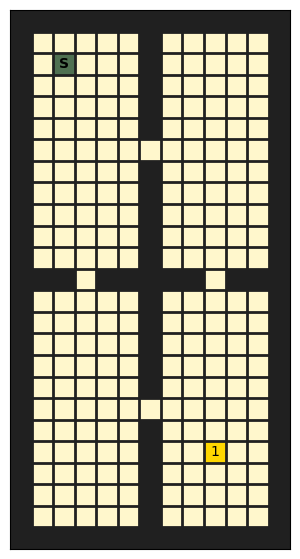

In [70]:
layout = np.loadtxt("../environments/gridworld_layouts/four_rooms.txt", comments="//", dtype=str)
env = GridWorld(layout, init_coords=[(2, 2)], terminal_coords=[(20, 9)], reward_coords={(20, 9): 1}, stochasticity=0., default_reward=-0.01)
env.name = "four_rooms"
env.reset()
env.render()

Neumann series computation of SR:
$$\mathbf{\Psi}_\pi = \sum^\infty_{t=0}\left(\gamma \mathbf{P}_\pi\right)^t = \left(\mathbf{I}-\gamma \mathbf{P}_\pi\right)^{-1}$$

In [71]:

def render_sr(env, sr, obs_coord, title, figsize=(10, 7)):
        render_colours  = OrderedDict(
            block_colour= "#101010", # black -1
            space_colour= "#fff7cc",  # off-white 0
        )
                
        # Creating a colour map?
        bounds = list(range(3))
        cmap = colors.ListedColormap(render_colours.values())
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        render_grid = deepcopy(env.grid)
        # Creating the figure and axes
        fig, ax = plt.subplots(figsize=figsize)
        obs_valid = env.coord_to_valid_state[obs_coord]
        
        # Rendering the grid with specified colours as the base layer
        ax.imshow(render_grid, cmap=cmap, norm=norm, zorder=0)

        # Adding lines in a grid on top
        ax.grid(which = 'major', axis = 'both', linestyle = '-', color = 'k', linewidth = 2, zorder = 1)
        
        ax.set_xticks(np.arange(-0.5, render_grid.shape[1] , 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(-0.5, render_grid.shape[0], 1))
        ax.set_yticklabels([])
        ax.tick_params(left=False, bottom=False)

        # State from which to measure SR
        ax.annotate("X", obs_coord[::-1], va="center", ha="center", c="black", weight = "bold")
        
        # Annotate init_state
        if obs_coord not in env._init_coords:
            for coord in env._init_coords:
                ax.annotate("I", coord[::-1], va="center", ha="center", c="black", weight = "bold")

        # Annotate rewarded states
        for coord in env._terminal_coords:
            ax.annotate("T", coord[::-1], va="center", weight="bold", ha="center", c="black") # gold

        sr_grid = render_grid[:, :]
        sr_vec = sr[obs_valid, :]
        opacity = np.zeros_like(sr_grid, dtype=np.float32)


        for i, val in enumerate(sr_vec):
            tmp_coord = env.valid_state_to_coord[i]
            sr_grid[tmp_coord] = val
            opacity[tmp_coord] = 1.


        plt.title(title)
        sr_heat_map = ax.imshow(sr_grid, cmap="viridis", alpha=opacity, zorder=1)
        fig.colorbar(sr_heat_map)

        plt.show()

In [72]:
buffer, agent, epi_steps = run_episodic(SRQLearningAgent(env.num_valid_states), env=env, num_episodes=10, save=True)

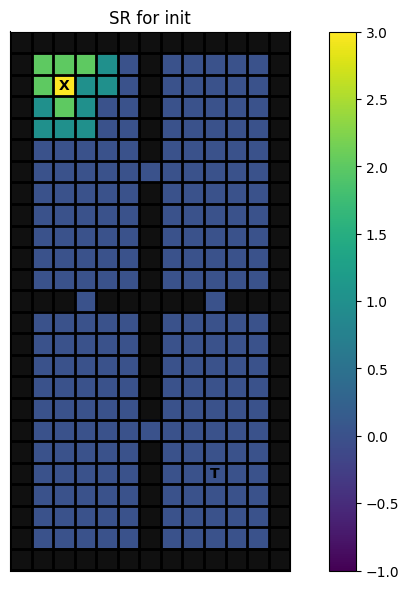

In [73]:
render_sr(env, deepcopy(agent.sr), (2,2), "SR for init")